# Exploring the Voc4Cat Vocabulary with Python

This notebook demonstrates how to download, query, and visualize the
[Voc4Cat](https://w3id.org/nfdi4cat/voc4cat) SKOS vocabulary using Python.

Voc4Cat is a controlled vocabulary for catalysis disciplines, maintained as part of the
[NFDI4Cat](https://nfdi4cat.org/) initiative. It uses the
[SKOS](https://www.w3.org/TR/skos-reference/) standard to provide persistent identifiers
and textual definitions for catalysis concepts.

**What you will learn:**
1. How to download and load the vocabulary into an RDF graph
2. How to query for concepts, labels, and definitions
3. How to navigate the concept hierarchy (broader/narrower)
4. How to search for concepts by text
5. How to visualize a portion of the concept hierarchy as a graph

## Setup

We use [rdflib](https://rdflib.readthedocs.io/) for working with RDF data,
and [networkx](https://networkx.org/) with [matplotlib](https://matplotlib.org/)
for graph visualization.

Install the dependencies (if not already installed):
```
pip install -r requirements.txt
```

In [1]:
from rdflib import Graph, Namespace, URIRef
from rdflib.namespace import SKOS, RDF

# The Voc4Cat namespace (prefix for concept IRIs)
VOC4CAT = Namespace("https://w3id.org/nfdi4cat/voc4cat_")
VOCAB_IRI = URIRef("https://w3id.org/nfdi4cat/voc4cat")

## Loading the vocabulary

The Voc4Cat vocabulary is published as a Turtle (.ttl) file on GitHub Pages.
We load the development version directly from its URL.
Alternatively, you could download the file first and load it from disk.

In [2]:
g = Graph()
g.parse("https://nfdi4cat.github.io/voc4cat/dev/voc4cat.ttl", format="turtle")
print(f"Loaded {len(g)} triples from Voc4Cat.")

Loaded 7557 triples from Voc4Cat.


## Basic statistics

Let's count the main elements in the vocabulary: concepts, collections, and top concepts.

In [3]:
concepts = set(g.subjects(predicate=RDF.type, object=SKOS.Concept))
collections = set(g.subjects(predicate=RDF.type, object=SKOS.Collection))
top_concepts = set(g.objects(subject=VOCAB_IRI, predicate=SKOS.hasTopConcept))

print(f"Concepts:     {len(concepts)}")
print(f"Collections:  {len(collections)}")
print(f"Top concepts: {len(top_concepts)}")

Concepts:     560
Collections:  6
Top concepts: 4


## Top concepts

The top concepts are the roots of the concept hierarchy.
Every other concept in Voc4Cat is a narrower term of one of these.

In [4]:
for tc in sorted(top_concepts):
    label = g.value(tc, SKOS.prefLabel)
    definition = str(g.value(tc, SKOS.definition))
    # Shorten long definitions for display
    if len(definition) > 100:
        definition = definition[:100] + "..."
    concept_id = str(tc).split("_")[-1]
    print(f"{concept_id}  {label}")
    print(f"         {definition}\n")

0000180  physical entity
         Entity with a concrete and physical nature.

0000181  non-temporal abstract entity
         Any entity that cannot be located in space-time. E.g., mathematical entities, formal semantics eleme...

0000182  temporal abstract entity
         Anything that has a temporal dimension, whether it is an instantaneous point in time, a duration, or...

0000186  attributes
         A characteristic of an entity that is intrinsic to and cannot exist without the entity. E.g., proper...



## Looking up a specific concept

Each concept has a 7-digit numeric ID (e.g. `0000001`).
The full IRI is constructed by appending the ID to the namespace prefix:
`https://w3id.org/nfdi4cat/voc4cat_0000001`

Let's write a function to look up a concept by its ID and display its properties.

In [5]:
def lookup_concept(graph, concept_id):
    """Look up a Voc4Cat concept by its numeric ID (e.g. '0000001')."""
    concept = VOC4CAT[concept_id]
    label = graph.value(concept, SKOS.prefLabel)
    if label is None:
        print(f"No concept found with ID {concept_id}")
        return

    definition = graph.value(concept, SKOS.definition)
    broader = [graph.value(b, SKOS.prefLabel) for b in graph.objects(concept, SKOS.broader)]
    narrower = [graph.value(n, SKOS.prefLabel) for n in graph.objects(concept, SKOS.narrower)]
    alt_labels = [str(a) for a in graph.objects(concept, SKOS.altLabel)]

    print(f"Concept:    {concept}")
    print(f"Label:      {label}")
    print(f"Definition: {definition}")
    if alt_labels:
        print(f"Alt labels: {', '.join(alt_labels)}")
    if broader:
        print(f"Broader:    {', '.join(str(b) for b in broader)}")
    if narrower:
        print(f"Narrower:   {', '.join(str(n) for n in narrower)}")


# Example: photocatalysis
lookup_concept(g, "0000001")

Concept:    https://w3id.org/nfdi4cat/voc4cat_0000001
Label:      photocatalysis
Definition: A process which catalyzes a chemical reaction through the absorption of sufficient light energy by a photocatalyst.
Broader:    catalysis research field


## Searching for concepts

We can search for concepts by matching against their preferred and alternate labels.

In [6]:
def search_concepts(graph, query, limit=10):
    """Search for concepts whose preferred or alternate labels contain the query string."""
    query_lower = query.lower()
    results = []
    for concept in graph.subjects(predicate=RDF.type, object=SKOS.Concept):
        for label in graph.objects(concept, SKOS.prefLabel):
            if query_lower in str(label).lower():
                results.append((concept, str(label), "prefLabel"))
        for label in graph.objects(concept, SKOS.altLabel):
            if query_lower in str(label).lower():
                pref = str(graph.value(concept, SKOS.prefLabel))
                results.append((concept, pref, f"altLabel: {label}"))

    # Deduplicate by concept IRI
    seen = set()
    count = 0
    for uri, lbl, match_type in results:
        if uri not in seen and count < limit:
            seen.add(uri)
            concept_id = str(uri).split("_")[-1]
            print(f"  {concept_id}  {lbl}  ({match_type})")
            count += 1


print("Search results for 'catalysis':")
search_concepts(g, "catalysis")

Search results for 'catalysis':
  0000204  biocatalysis  (prefLabel)
  0000207  enzyme catalysis  (prefLabel)
  0000208  organocatalysis  (prefLabel)
  0000216  electrocatalysis  (prefLabel)
  0000217  asymmetric catalysis  (prefLabel)
  0000232  acid catalysis  (prefLabel)
  0000233  base catalysis  (prefLabel)
  0000246  nanocatalysis  (prefLabel)
  0000294  homogeneous catalysis  (prefLabel)
  0000296  catalysis  (prefLabel)


## Navigating the hierarchy

SKOS uses `skos:broader` and `skos:narrower` to express hierarchical relationships.
We can walk up the hierarchy from any concept to a top concept by following `skos:broader` links.

In [7]:
def path_to_top(graph, concept_iri):
    """Follow broader relations from a concept up to a top concept."""
    path = [concept_iri]
    current = concept_iri
    while True:
        parent = graph.value(current, SKOS.broader)
        if parent is None:
            break
        path.append(parent)
        current = parent
    return path


# Show the path from "photocatalysis" (0000001) to the top
path = path_to_top(g, VOC4CAT["0000001"])
print("Hierarchy from top concept down to 'photocatalysis':\n")
for i, concept in enumerate(reversed(path)):
    label = g.value(concept, SKOS.prefLabel)
    concept_id = str(concept).split("_")[-1]
    print(f"{'  ' * i}{label} ({concept_id})")

Hierarchy from top concept down to 'photocatalysis':

non-temporal abstract entity (0000181)
  catalysis research field (0000196)
    photocatalysis (0000001)


## Visualizing the concept hierarchy

Let's visualize a portion of the concept hierarchy as a graph.
We pick the "catalysis research field" concept (0000196) as the root,
which has manageable number of narrower concepts -- all recognizable catalysis sub-fields.

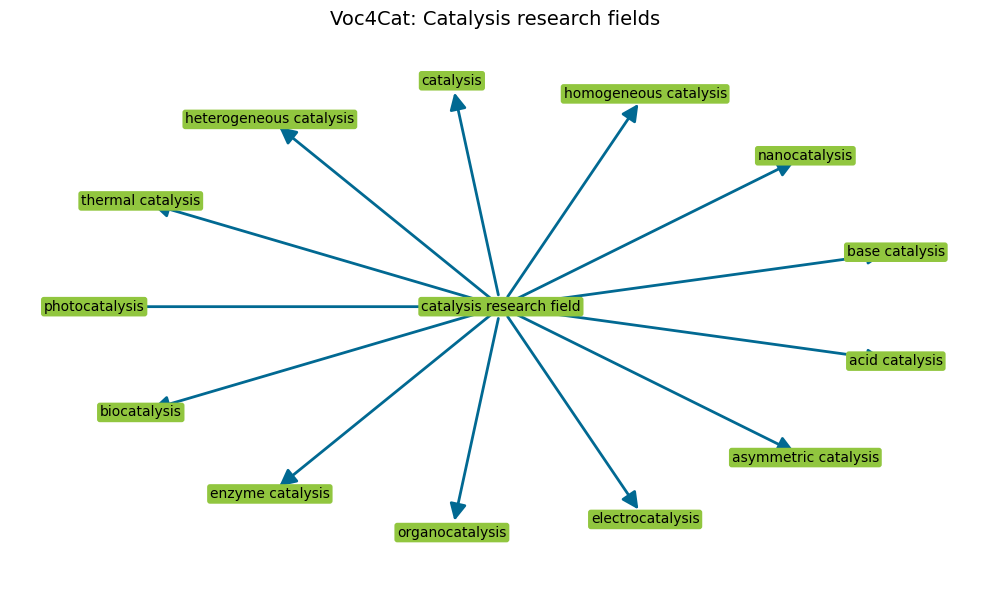

In [8]:
import networkx as nx
import matplotlib.pyplot as plt


def build_subtree(graph, root_iri, max_depth=1):
    """Build a networkx DiGraph of narrower concepts starting from root_iri."""
    G = nx.DiGraph()
    root_label = str(graph.value(root_iri, SKOS.prefLabel))
    G.add_node(root_label)

    def add_children(concept, parent_label, depth):
        if depth >= max_depth:
            return
        for child in graph.objects(concept, SKOS.narrower):
            child_label = str(graph.value(child, SKOS.prefLabel))
            G.add_node(child_label)
            G.add_edge(parent_label, child_label)
            add_children(child, child_label, depth + 1)

    add_children(root_iri, root_label, 0)
    return G


tree = build_subtree(g, VOC4CAT["0000196"], max_depth=1)

root_label = "catalysis research field"
children = [n for n in tree.nodes() if n != root_label]

fig, ax = plt.subplots(figsize=(10, 6))
pos = nx.shell_layout(tree, nlist=[[root_label], children])

nx.draw_networkx_edges(
    tree, pos, ax=ax,
    edge_color="#016992", width=2,
    arrows=True, arrowsize=25,
)

bbox_style = dict(boxstyle="round,pad=0.2", facecolor="#91c63f", edgecolor="none")
nx.draw_networkx_labels(tree, pos, ax=ax, font_size=10, bbox=bbox_style)

ax.set_title("Voc4Cat: Catalysis research fields", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Text-based tree

For a compact overview, an indented text tree can also be useful.
You can adjust `max_depth` to explore deeper levels of the hierarchy.

In [9]:
def print_tree(graph, concept, indent=0, max_depth=2):
    """Print an indented text tree of narrower concepts."""
    if indent > max_depth:
        return
    label = graph.value(concept, SKOS.prefLabel)
    concept_id = str(concept).split("_")[-1]
    print(f"{'  ' * indent}{label} ({concept_id})")
    for child in sorted(graph.objects(concept, SKOS.narrower)):
        print_tree(graph, child, indent + 1, max_depth)


print_tree(g, VOC4CAT["0000196"], max_depth=1)

catalysis research field (0000196)
  photocatalysis (0000001)
  biocatalysis (0000204)
  enzyme catalysis (0000207)
  organocatalysis (0000208)
  electrocatalysis (0000216)
  asymmetric catalysis (0000217)
  acid catalysis (0000232)
  base catalysis (0000233)
  nanocatalysis (0000246)
  homogeneous catalysis (0000294)
  catalysis (0000296)
  heterogeneous catalysis (0007001)
  thermal catalysis (0007002)


## Querying with SPARQL

rdflib supports [SPARQL](https://www.w3.org/TR/sparql11-query/),
the standard query language for RDF data.
Here we find all concepts that are narrower terms of "catalysis research field"
and retrieve their labels and definitions.

In [10]:
query = """
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX voc4cat: <https://w3id.org/nfdi4cat/voc4cat_>

SELECT ?concept ?label ?definition
WHERE {
    ?concept skos:broader voc4cat:0000196 ;
             skos:prefLabel ?label ;
             skos:definition ?definition .
    FILTER (lang(?label) = "en")
}
ORDER BY ?label
"""

results = g.query(query)
print(f"Narrower concepts of 'catalysis research field' ({len(results)} results):\n")
for row in results:
    concept_id = str(row.concept).split("_")[-1]
    print(f"  {concept_id}  {row.label}")

Narrower concepts of 'catalysis research field' (13 results):

  0000232  acid catalysis
  0000217  asymmetric catalysis
  0000233  base catalysis
  0000204  biocatalysis
  0000296  catalysis
  0000216  electrocatalysis
  0000207  enzyme catalysis
  0007001  heterogeneous catalysis
  0000294  homogeneous catalysis
  0000246  nanocatalysis
  0000208  organocatalysis
  0000001  photocatalysis
  0007002  thermal catalysis


## Summary

This notebook showed how to:
- Download and load the Voc4Cat vocabulary using rdflib
- Query concepts by ID or by text search
- Navigate the broader/narrower hierarchy
- Visualize subtrees of the concept graph
- Use SPARQL for structured queries

**Further resources:**
- [Voc4Cat documentation](https://nfdi4cat.github.io/voc4cat/) -- main project site
- [How to use Voc4Cat](https://nfdi4cat.github.io/voc4cat/docs_usage/how-to-use.html) -- download, API access, and integration guide
- [How to contribute](https://nfdi4cat.github.io/voc4cat/docs_usage/how-to-contribute.html) -- add new concepts to the vocabulary
- [Skosmos at ZB MED](https://semanticlookup.zbmed.de/skosmos/voc4cat/) -- browse and search via REST API

The Voc4Cat vocabulary is released under [CC0-1.0](https://creativecommons.org/publicdomain/zero/1.0/).